In [97]:
# Bank Marketing Classifier Comparison

## Overview
# This notebook analyzes and compares different machine learning classifiers
# to predict whether a customer will subscribe to a term deposit

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


In [100]:
# Load dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
!wget -q $data_url -O bank.zip
!unzip -o bank.zip
df = pd.read_csv("bank.csv", sep=';')

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [101]:
## Data Exploration and Cleaning
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None
age          0
job          0
marital      0
education    0
default      0
balance      0
hous

In [104]:
# Replace 'unknown' with NaN
df.replace('unknown', pd.NA, inplace=True)
print(df.isna().sum())

# Cap outliers
for col in ['balance', 'age']:
    upper = df[col].quantile(0.99)
    lower = df[col].quantile(0.01)
    df[col] = np.clip(df[col], lower, upper)

# Feature engineering
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])
df['has_prev_contact'] = (df['previous'] > 0).astype(int)

df = df.drop_duplicates()

# Label encode target
le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])

# One-hot encoding
df_encoded = pd.get_dummies(df.drop('y', axis=1), drop_first=True)
df_encoded['y'] = df['y']

age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64


In [105]:

# Define X, y
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']


In [106]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [107]:

# SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [108]:

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:

## Modeling and Evaluation
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    results[name] = {
        "CV Score": score,
        "Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

In [110]:


## Grid Search for Best Hyperparameters
# KNN
grid_knn = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=5)
grid_knn.fit(X_train_scaled, y_train)

# Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}, cv=5)
grid_lr.fit(X_train_scaled, y_train)

# Decision Tree
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 5]
}, cv=5)
grid_dt.fit(X_train_scaled, y_train)

# SVM
grid_svm = GridSearchCV(SVC(probability=True), {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}, cv=5)
grid_svm.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})

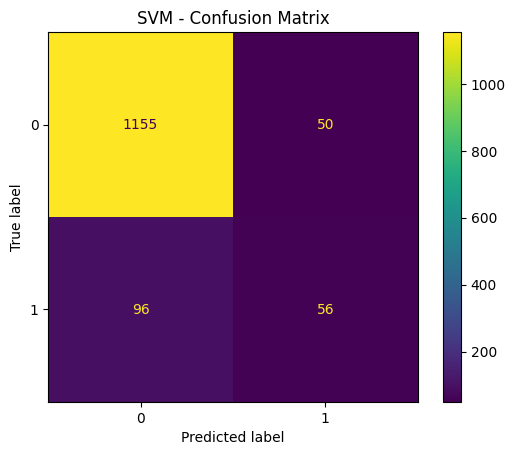

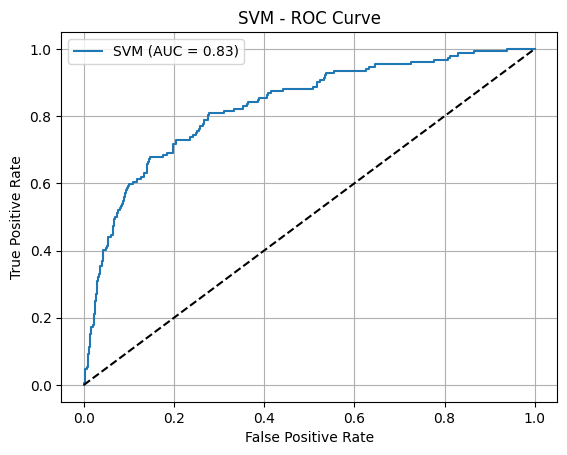

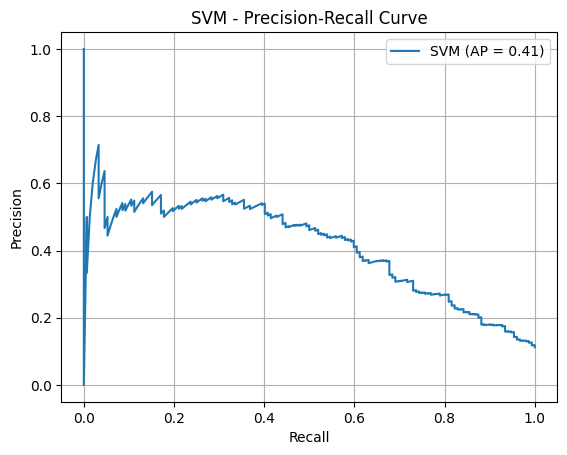


Model: KNN
Cross-Validation Score: 0.9186
Classification Report:
              precision    recall  f1-score      support
0              0.905929  0.951037  0.927935  1205.000000
1              0.358696  0.217105  0.270492   152.000000
accuracy       0.868828  0.868828  0.868828     0.868828
macro avg      0.632312  0.584071  0.599214  1357.000000
weighted avg   0.844632  0.868828  0.854294  1357.000000
Confusion Matrix:
[[1146   59]
 [ 119   33]]

Model: Logistic Regression
Cross-Validation Score: 0.9134
Classification Report:
              precision    recall  f1-score      support
0              0.927066  0.949378  0.938089  1205.000000
1              0.504065  0.407895  0.450909   152.000000
accuracy       0.888725  0.888725  0.888725     0.888725
macro avg      0.715566  0.678636  0.694499  1357.000000
weighted avg   0.879685  0.888725  0.883519  1357.000000
Confusion Matrix:
[[1144   61]
 [  90   62]]

Model: Decision Tree
Cross-Validation Score: 0.9007
Classification Report:
  

In [111]:



## SVM Evaluation Plots
ConfusionMatrixDisplay.from_estimator(grid_svm, X_test_scaled, y_test)
plt.title("SVM - Confusion Matrix")
plt.show()

y_probs = grid_svm.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("SVM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, label=f"SVM (AP = {average_precision_score(y_test, y_probs):.2f})")
plt.title("SVM - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

## Model Summary
for name, metrics in results.items():
    print(f"\nModel: {name}")
    print(f"Cross-Validation Score: {metrics['CV Score']:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(metrics['Report']).transpose())
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])